In [1]:
# The trust-region Newton method applied to LJ7 cluster in 3D 

import numpy as np
import scipy
import matplotlib.pyplot as plt
from LJhelpers import *

In [2]:
# Set up the initial configuration

# Four lical minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid 
# f2 = -15.93504306 Capped octahedron 
# f3 = -15.59321094 Tricapped tetrahedron 
# f4 = -15.53306005 Bicapped trigonal bipyramid

# Options: model = 0,1,2,3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.


In [3]:
def cauchy_point(B,g,Delta):
    ng = np.linalg.norm(g)
    ps = -g*Delta/ng
    aux = np.dot(g,B @ g)
    if( aux <= 0 ):
        p = ps
    else:
        a = np.minimum(ng**3/(Delta*aux),1)
        p = ps*a
    return p

In [4]:
def descend(initial, direction):
        Na = 7 #the number of atoms
        rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
        tol = 1e-6 # stop iterations when ||grad f|| < tol
        iter_max = 200 # the maximal number of iterations
        draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
        # parameters for trust region
        Delta_max = 5 # the max trust-region radius
        Delta_min = 1e-12 # the minimal trust-region radius
        Delta = 1 # the initial radius
        eta = 0.1 # step rejection parameter
        subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
        tol_sub = 1e-1 # relative tolerance for the subproblem
        rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
        rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius
        # select the initial configuration
        model = initial
        if( model > 0):
            Na = 7
        xyz = initial_configuration(model,Na,rstar)
        # drawconf(xyz,0.5*rstar);
        
        x = remove_rotations_translations(xyz)
        # drawconf(LJvector2array(x),0.5*rstar)
        print("LJpot = ",LJpot(x))
        #todo move all the initialization inside
            # initialization
        f = LJpot(x)
        g = LJgrad(x)
        x_old=np.zeros(len(x))
        g_old=np.zeros(len(g))
        B=np.eye(len(x))
        norm_g = np.linalg.norm(g)
        print("Initially, f = ",f,", ||grad f|| = ",norm_g)
        
        fvals = np.zeros(iter_max)
        fvals[0] = f
        ngvals = np.zeros(iter_max)
        ngvals[0] = norm_g
        Delta = 1 # the initial trust region radius
        I = np.eye(np.size(x),dtype = float)
        
        itr = 1
    
        while (norm_g > tol and itr < iter_max):      
            # solve the constrained minimization problem 
            if direction=='Newton':
                subproblem_method='exact'
                B = LJhess(x)
                
            elif direction=='BFGS':
                subproblem_method='dogleg'
                s=x-x_old
                y=g-g_old
                B=B-(np.outer(B.dot(s),B.dot(s)))/(s.dot(B).dot(s) + 0)+(np.outer(y,y))/(y.dot(s))# +1e-12)
                
            flag_boundary = 0 
                # check if B is SPD
            eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
            j_sub = 0
            if( eval_min > 0 ): # B is SPD: B = R'*R, R'*R*p = -g 
                if subproblem_method=='exact':
                    p = scipy.linalg.solve(B,-g)
                    p_norm = np.linalg.norm(p)
                    if( p_norm > Delta ): # else: we are done with solbing the subproblem
                        flag_boundary = 1    
                if subproblem_method=='dogleg':
                    p_u = cauchy_point(B,g,Delta)
                    p_b = scipy.linalg.solve(B,-g)
                    if np.linalg.norm(p_b) <= Delta:
                        p=p_b
                    elif np.linalg.norm(p_u) >= Delta:
                        p=Delta*p_u/np.linalg.norm(p_u)
                    else:
                        p_diff = p_b - p_u
                        a = np.dot(p_diff, p_diff)
                        b = 2 * np.dot(p_u, p_diff)
                        c = np.dot(p_u, p_u) - Delta**2
                    
                        discr = b**2 - 4 * a * c
                        if discr < 0:
                            t = 0  
                        else:
                            t = (-b + np.sqrt(discr)) / (2 * a)
                        p = p_u + t * p_diff
                    p_norm = np.linalg.norm(p)
                    flag_boundary = 0
            else:
                flag_boundary = 1
            if( flag_boundary == 1 ): # solution lies on the boundary
                lam_min = np.maximum(-eval_min,0.0)
                lam = lam_min + 1
                R = scipy.linalg.cholesky(B+lam*I,lower = False)
                flag_subproblem_success = 0;
                while( j_sub < subproblem_iter_max ):
                    j_sub = j_sub + 1;
                    p = scipy.linalg.solve_triangular(np.transpose(R),-g,lower = True)
                    p = scipy.linalg.solve_triangular(R,p,lower = False)
                    p_norm = np.linalg.norm(p)
                    dd = np.absolute(p_norm - Delta)
                    if( dd < tol_sub*Delta ):
                        flag_subproblem_success = 1
                        break
                    q = scipy.linalg.solve_triangular(np.transpose(R),p,lower = True)
                    q_norm = np.linalg.norm(q);
                    dlam = ((p_norm/q_norm)**2)*(p_norm - Delta)/Delta
                    lam_new = lam + dlam;
                    if (lam_new > lam_min):
                        lam = lam_new
                    else:
                        lam = 0.5*(lam + lam_min)
                    R = scipy.linalg.cholesky(B+lam*I,lower = False)
                if( flag_subproblem_success == 0 ):
                    p = cauchy_point(B,g,Delta)
    
            # assess the progress
            xnew = x + p
            fnew = LJpot(xnew)
            gnew = LJgrad(xnew)
            mnew = f + np.dot(g,p) + 0.5*np.dot(p,B @ p)
            rho = (f - fnew)/(f - mnew+1e-14)
            # adjust the trust region
            if( rho < rho_bad ):
                Delta = np.maximum(0.25*Delta,Delta_min)
            else:
                #todo if(  rho > rho_good and flag_boundary == 1 ):
                Delta = np.minimum(Delta_max,2*Delta)
            # accept or reject step
            if( rho > eta ):  # accept step          
                x = xnew
                f = fnew
                g = gnew
                norm_g = np.linalg.norm(g)
                # print(f'Accept: itr {itr}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}, method = {subproblem_method}')#todo {j_sub}')
            else:
                pass
                # print(f'Reject: itr {itr}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}, method = {subproblem_method}')#todo  {j_sub}')
            if( itr % 20 == 19):
                # restore all coordinates
                xyz = LJvector2array(x)
                # drawconf(xyz,0.5*rstar)
            fvals[itr] = f
            ngvals[itr] = norm_g
            itr = itr + 1
        print(f'Result: itr {itr}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}, method = {subproblem_method}')

        return fvals, ngvals , itr
        


LJpot =  -11.517662869490488
Initially, f =  -11.517662869490488 , ||grad f|| =  16.468632904952266
Result: itr 10: f = -16.5053841680, |df| = 7.1584e-09, rho = 9.9999e-01, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  -11.517662869490488
Initially, f =  -11.517662869490488 , ||grad f|| =  16.468632904952266
Result: itr 200: f = -16.5053841660, |df| = 2.1922e-04, rho = 8.2770e-01, Delta = 7.6294e-06, j_sub = 0, method = dogleg


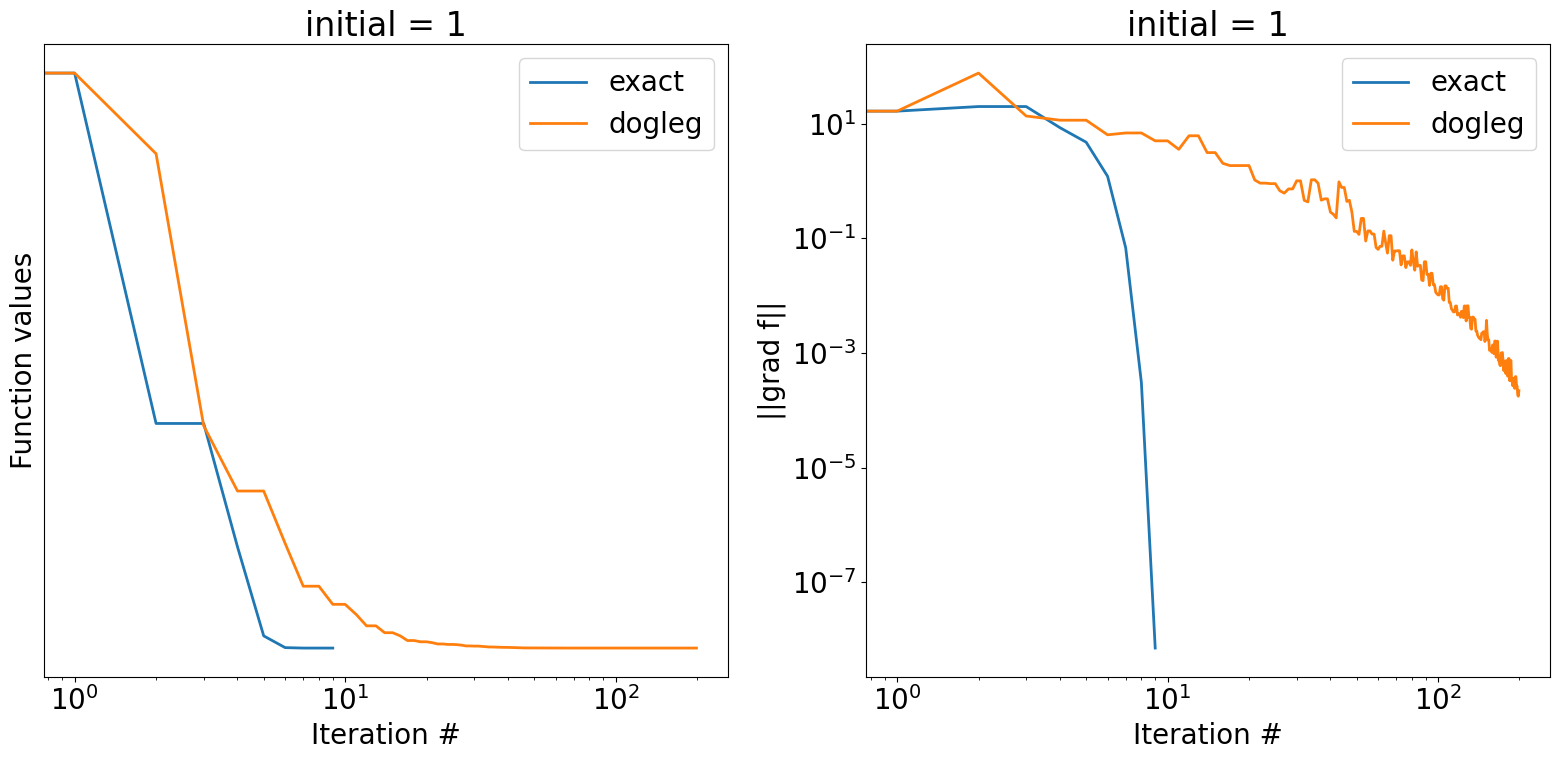

LJpot =  -15.921231995884773
Initially, f =  -15.921231995884773 , ||grad f|| =  2.119680077530262
Result: itr 4: f = -15.9350430605, |df| = 7.8493e-09, rho = 1.0000e+00, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  -15.921231995884773
Initially, f =  -15.921231995884773 , ||grad f|| =  2.119680077530262
Result: itr 200: f = -15.9350430605, |df| = 1.1579e-06, rho = 0.0000e+00, Delta = 1.0000e-12, j_sub = 0, method = dogleg


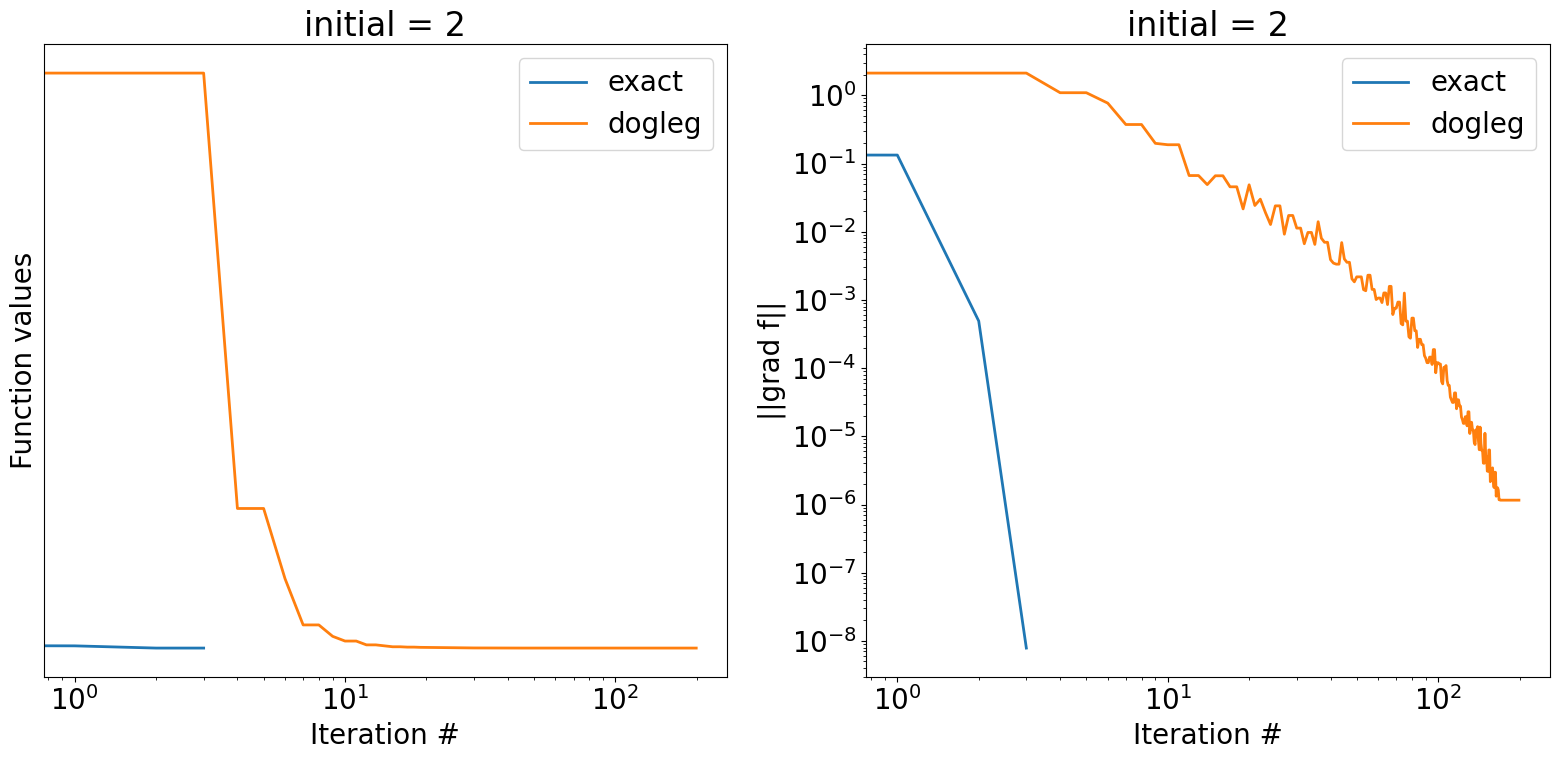

LJpot =  -15.581469160072078
Initially, f =  -15.581469160072078 , ||grad f|| =  1.46083663929382
Result: itr 4: f = -15.5932109382, |df| = 1.7979e-08, rho = 1.0000e+00, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  -15.581469160072078
Initially, f =  -15.581469160072078 , ||grad f|| =  1.46083663929382
Result: itr 143: f = -15.5932109382, |df| = 9.9258e-07, rho = 3.4395e-01, Delta = 1.4901e-08, j_sub = 0, method = dogleg


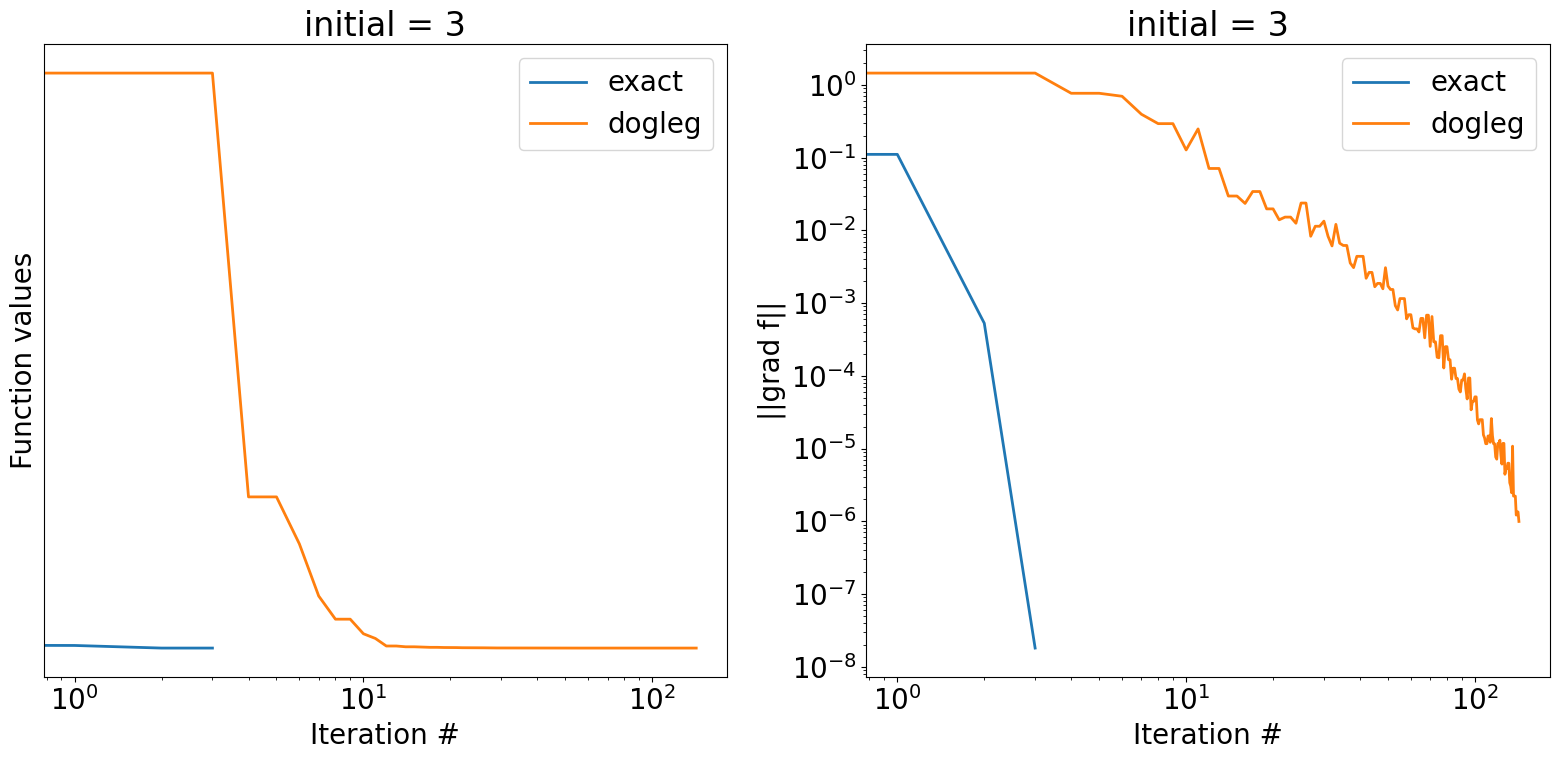

LJpot =  -15.522210169999571
Initially, f =  -15.522210169999571 , ||grad f|| =  1.2854375635525659
Result: itr 4: f = -15.5330600546, |df| = 1.9559e-09, rho = 9.9996e-01, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  -15.522210169999571
Initially, f =  -15.522210169999571 , ||grad f|| =  1.2854375635525659
Result: itr 159: f = -15.5330600546, |df| = 9.7040e-07, rho = 4.7849e-01, Delta = 2.9802e-08, j_sub = 0, method = dogleg


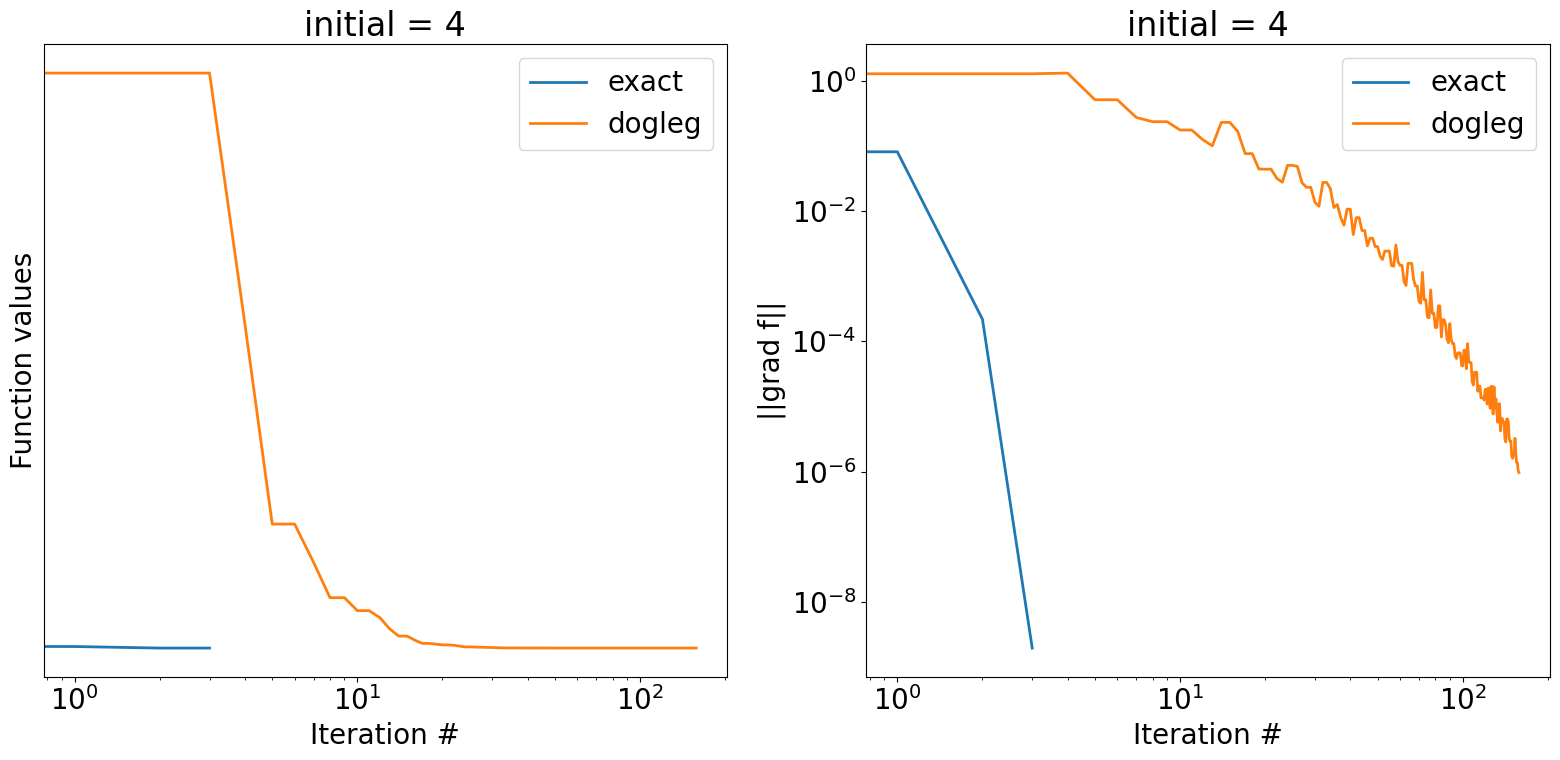

In [5]:
#4 initials near the 4 minimums 
for initial in range(1,5):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(16,8))
    direction_dict = {1:"Newton",2:"BFGS"} # 
    plot_dict = {1:"exact",2:"dogleg"} # 

    for direction in direction_dict:
        fvals, ngvals , itr=descend(initial, direction_dict[direction])
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(itr),fvals[0:itr],linewidth = 2, label=plot_dict[direction]) #todo less than itermax
        plt.title("initial = "+str(initial))
        plt.xlabel("Iteration #")
        plt.xscale("log")
        plt.ylabel("Function values")
        #plt.yscale("log")
        plt.yscale('symlog', linthresh=10)
        plt.legend()
        #second plot of gradients
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(itr),ngvals[0:itr],linewidth = 2, label=plot_dict[direction])
        plt.title("initial = "+str(initial))
        plt.xlabel("Iteration #")
        plt.xscale("log")
        plt.ylabel("||grad f||")
        plt.yscale("log")
        plt.legend()
    plt.tight_layout()    
    plt.show()



LJpot =  -6.919123493412594
Initially, f =  -6.919123493412594 , ||grad f|| =  8.306817915892017
Result: itr 38: f = -16.5053841680, |df| = 5.4420e-12, rho = 9.7151e-01, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  453.0837704772033
Initially, f =  453.0837704772033 , ||grad f|| =  8189.156179796701
Result: itr 200: f = -15.5328062877, |df| = 9.6561e-02, rho = -9.3719e-01, Delta = 4.8828e-04, j_sub = 0, method = dogleg


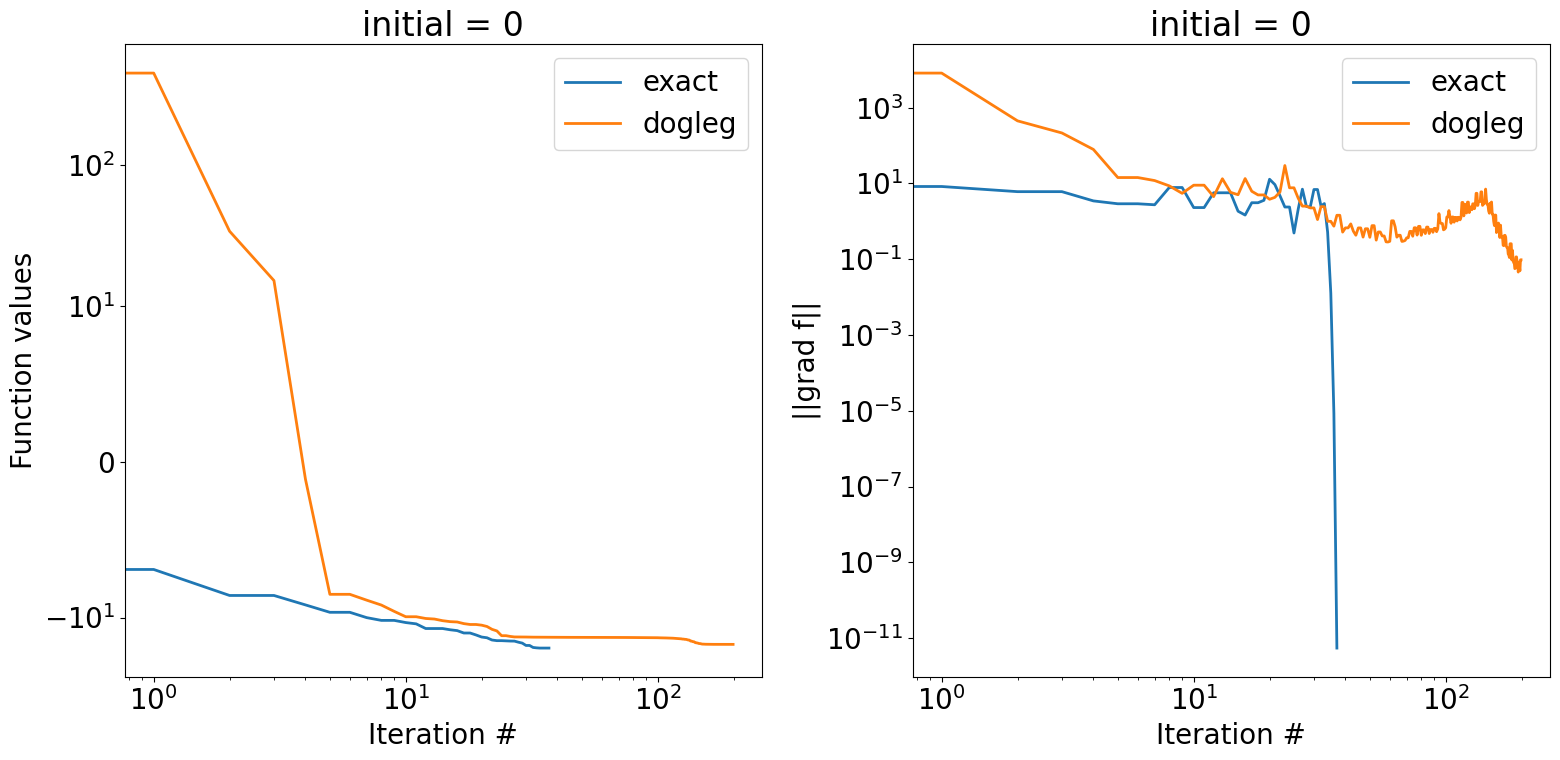

LJpot =  46.25247294168021
Initially, f =  46.25247294168021 , ||grad f|| =  892.3790327966989
Result: itr 48: f = -15.5330600546, |df| = 4.7485e-09, rho = 1.0000e+00, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  790261907.2006509
Initially, f =  790261907.2006509 , ||grad f|| =  46587884007.67537
Result: itr 200: f = -15.3221911553, |df| = 1.4662e+00, rho = 6.7916e-01, Delta = 3.1250e-02, j_sub = 3, method = dogleg


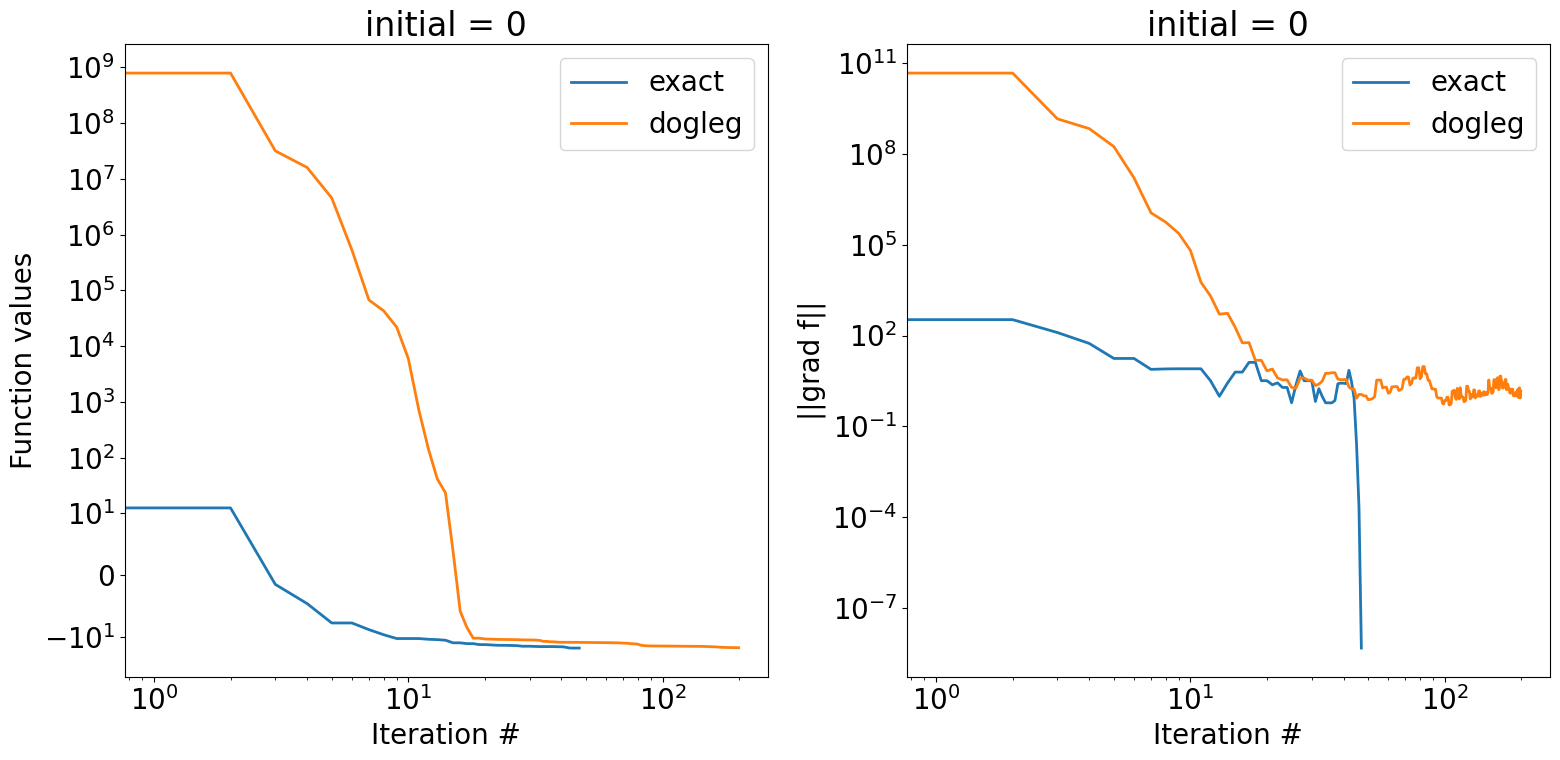

LJpot =  5175719030.841394
Initially, f =  5175719030.841394 , ||grad f|| =  356846014271.32465
Result: itr 200: f = -12.3047724242, |df| = 5.7122e-03, rho = 9.9983e-01, Delta = 5.0000e+00, j_sub = 5, method = exact
LJpot =  -7.126407593061491
Initially, f =  -7.126407593061491 , ||grad f|| =  7.420777624370344
Result: itr 200: f = -15.5147192927, |df| = 4.2360e-01, rho = 7.8220e-01, Delta = 3.9062e-03, j_sub = 0, method = dogleg


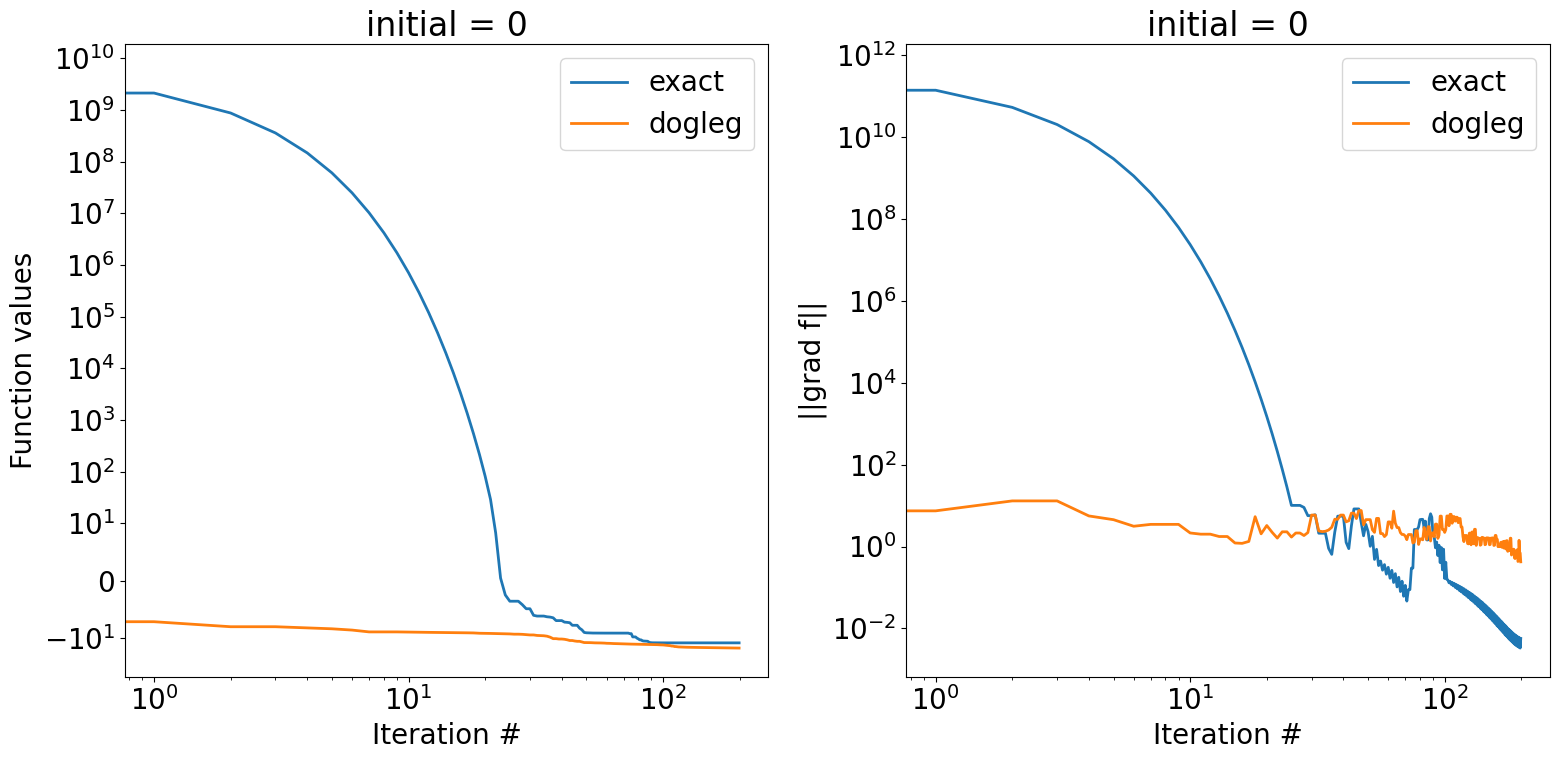

LJpot =  40112.617019565194
Initially, f =  40112.617019565194 , ||grad f|| =  1037582.9219862876
Result: itr 127: f = -15.5330600546, |df| = 1.0030e-09, rho = 9.9978e-01, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  1042243258604.846
Initially, f =  1042243258604.846 , ||grad f|| =  111808905596569.62
Result: itr 200: f = -14.1263357695, |df| = 1.1705e+00, rho = 1.1525e+00, Delta = 3.1250e-02, j_sub = 0, method = dogleg


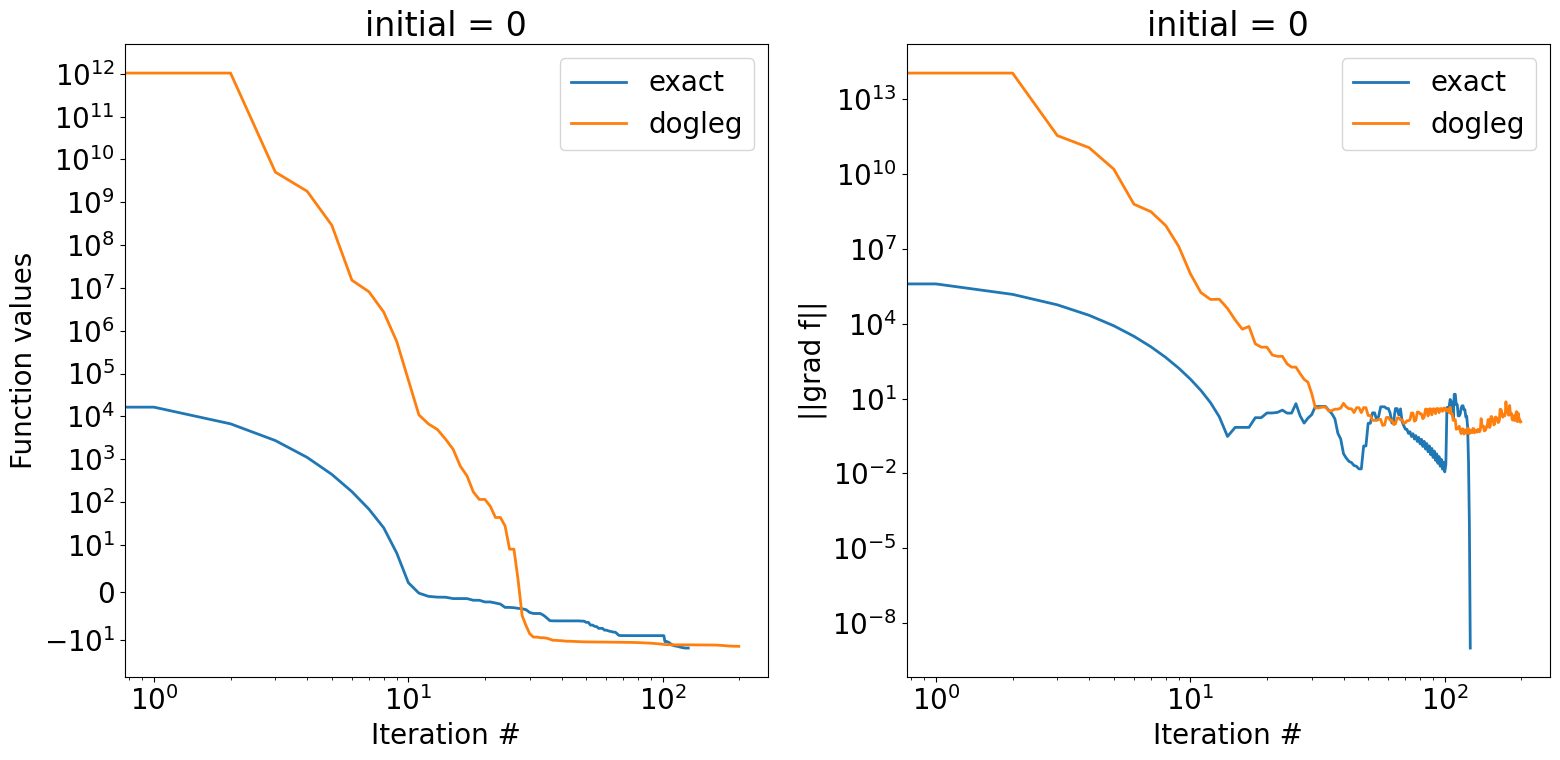

LJpot =  -7.479947379190472
Initially, f =  -7.479947379190472 , ||grad f|| =  10.106669964245537
Result: itr 29: f = -16.5053841680, |df| = 6.8282e-11, rho = 9.9515e-01, Delta = 2.0000e+00, j_sub = 0, method = exact
LJpot =  -9.454397621040696
Initially, f =  -9.454397621040696 , ||grad f|| =  10.79046232153815
Result: itr 200: f = -15.5251778947, |df| = 5.1002e-01, rho = -2.0410e+00, Delta = 3.9062e-03, j_sub = 0, method = dogleg


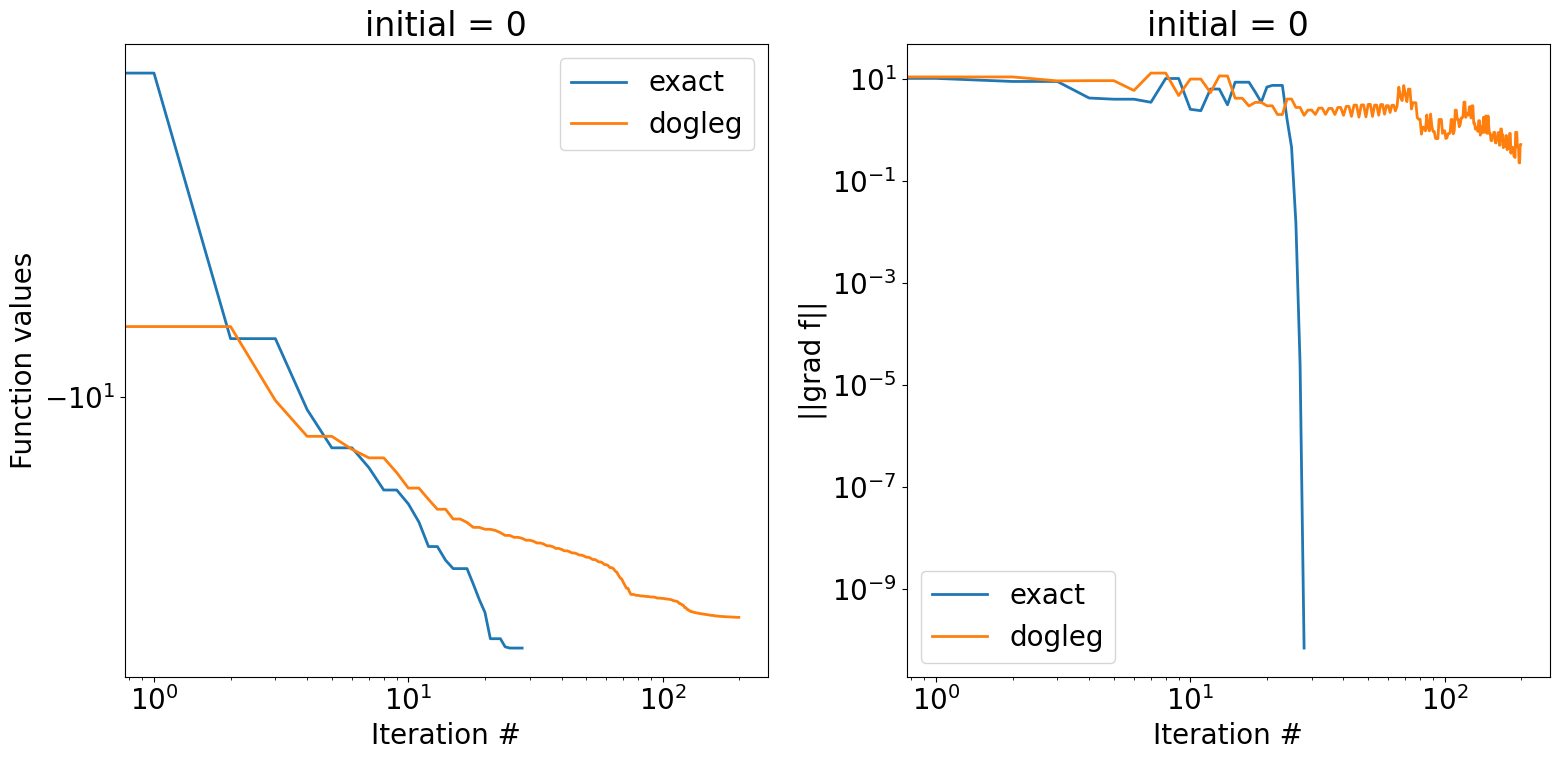

LJpot =  -6.9510214878942005
Initially, f =  -6.9510214878942005 , ||grad f|| =  8.565797490288217
Result: itr 32: f = -15.5932109382, |df| = 2.5433e-11, rho = 9.9566e-01, Delta = 2.0000e+00, j_sub = 0, method = exact
LJpot =  -5.822768433199027
Initially, f =  -5.822768433199027 , ||grad f|| =  38.85956489496906
Result: itr 200: f = -13.5960456640, |df| = 2.3071e-01, rho = 5.8592e-01, Delta = 3.9062e-03, j_sub = 0, method = dogleg


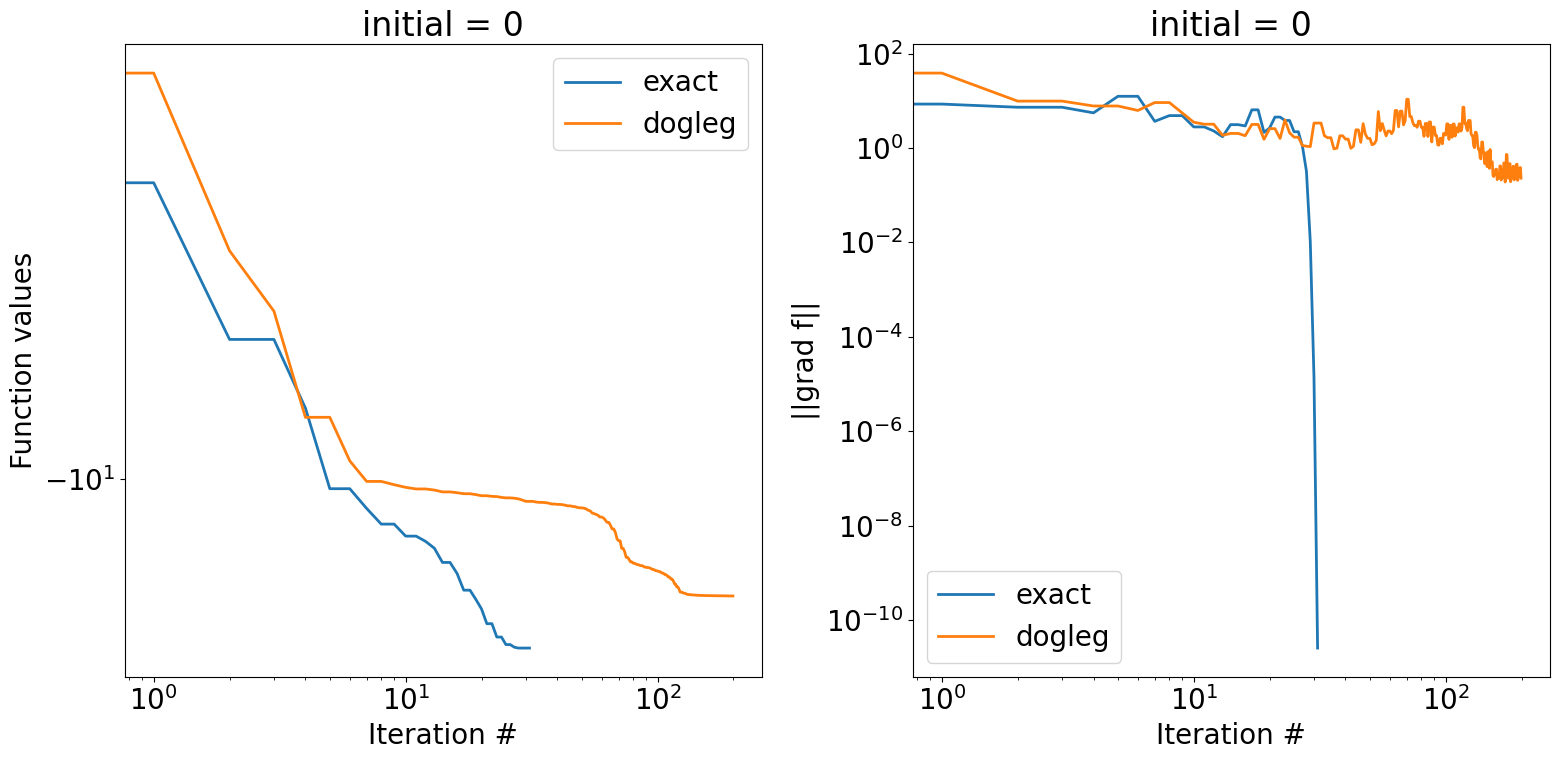

LJpot =  4.223665898160384
Initially, f =  4.223665898160384 , ||grad f|| =  204.47259182001025
Result: itr 35: f = -15.5330600546, |df| = 3.0838e-09, rho = 9.9997e-01, Delta = 2.0000e+00, j_sub = 0, method = exact
LJpot =  -7.936139235446195
Initially, f =  -7.936139235446195 , ||grad f|| =  7.460788555299447
Result: itr 200: f = -15.3308153133, |df| = 2.8979e+00, rho = 4.1615e-01, Delta = 3.1250e-02, j_sub = 3, method = dogleg


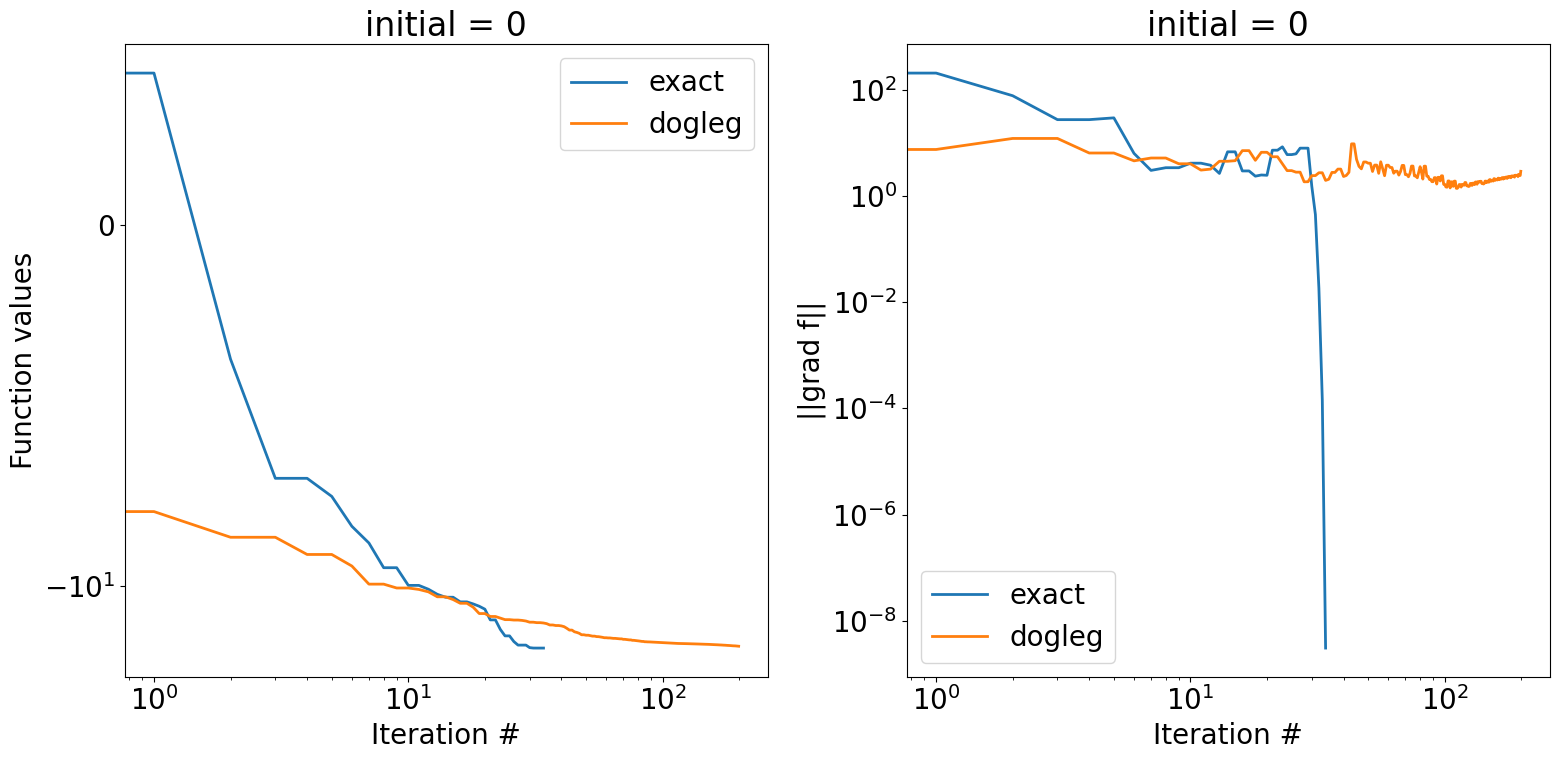

LJpot =  852929.0750571343
Initially, f =  852929.0750571343 , ||grad f|| =  28474361.400603116
Result: itr 143: f = -15.5932109382, |df| = 9.5746e-09, rho = 1.0000e+00, Delta = 2.5000e+00, j_sub = 0, method = exact
LJpot =  2.607098734432283
Initially, f =  2.607098734432283 , ||grad f|| =  198.60032549331464
Result: itr 200: f = -12.5888227094, |df| = 1.3524e+00, rho = 5.5907e-01, Delta = 3.1250e-02, j_sub = 0, method = dogleg


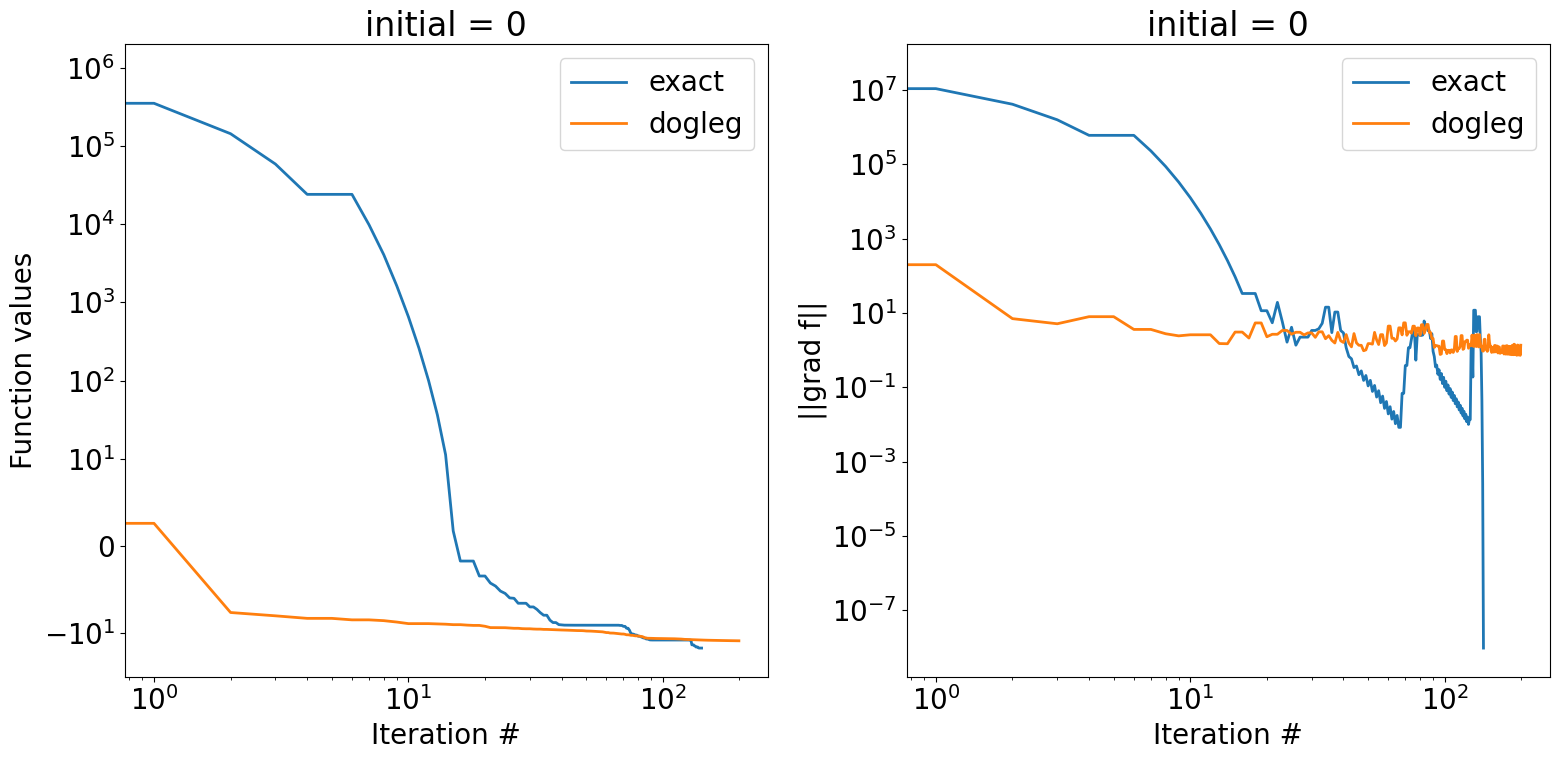

LJpot =  165.05459753821413
Initially, f =  165.05459753821413 , ||grad f|| =  2322.2657795570967
Result: itr 40: f = -15.5330600546, |df| = 5.1878e-12, rho = 9.8917e-01, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  95658307.25112982
Initially, f =  95658307.25112982 , ||grad f|| =  4729625333.877186
Result: itr 200: f = -15.5321633737, |df| = 2.2958e-01, rho = 6.4118e-01, Delta = 3.9062e-03, j_sub = 3, method = dogleg


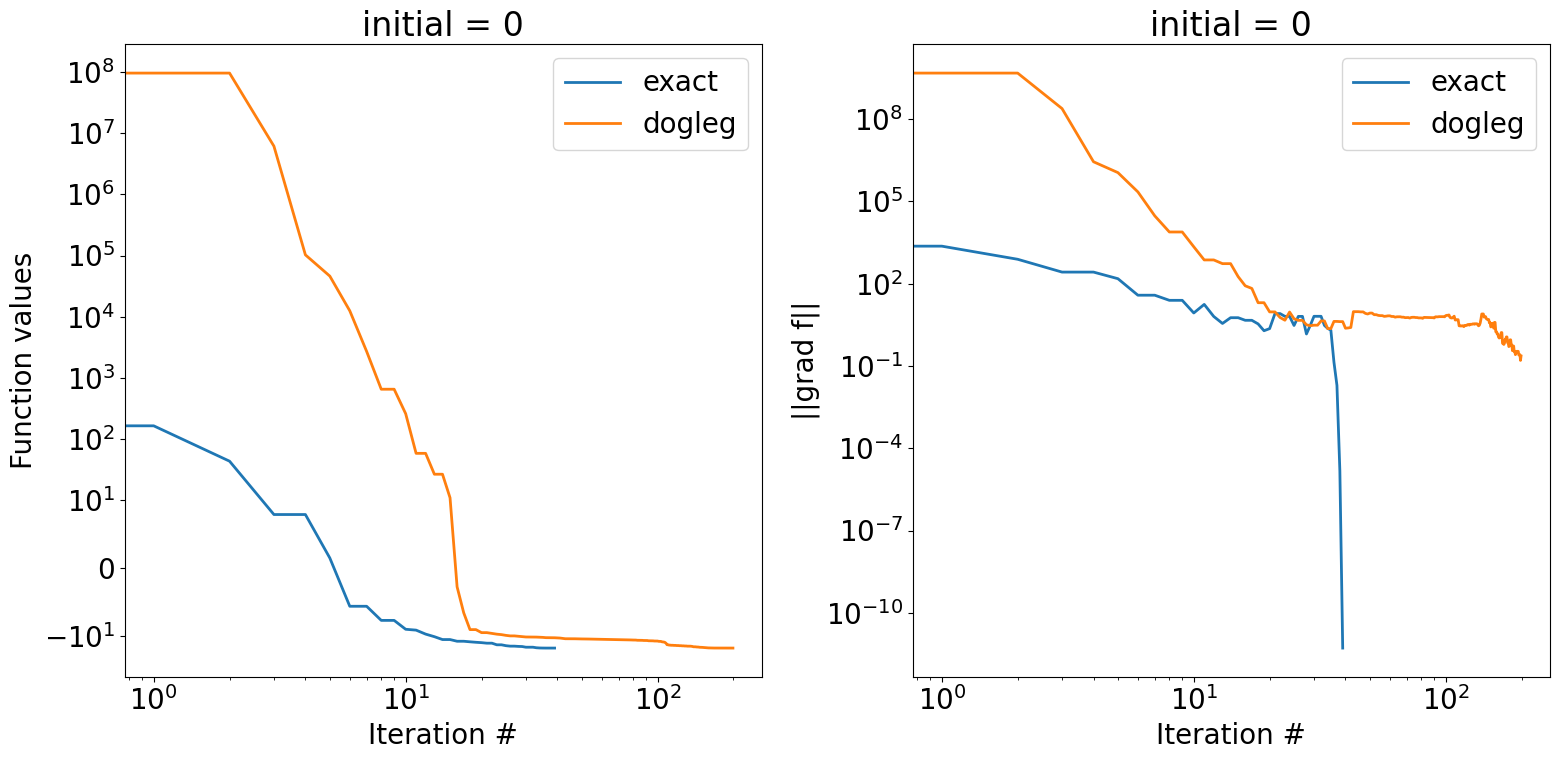

LJpot =  29.181730974798036
Initially, f =  29.181730974798036 , ||grad f|| =  639.1316454148935
Result: itr 19: f = -15.9350430605, |df| = 5.2488e-07, rho = 1.0002e+00, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  55910.33807415424
Initially, f =  55910.33807415424 , ||grad f|| =  1488572.4390628017
Result: itr 200: f = -14.6178708917, |df| = 1.4606e-01, rho = 1.0170e+00, Delta = 3.9062e-03, j_sub = 0, method = dogleg


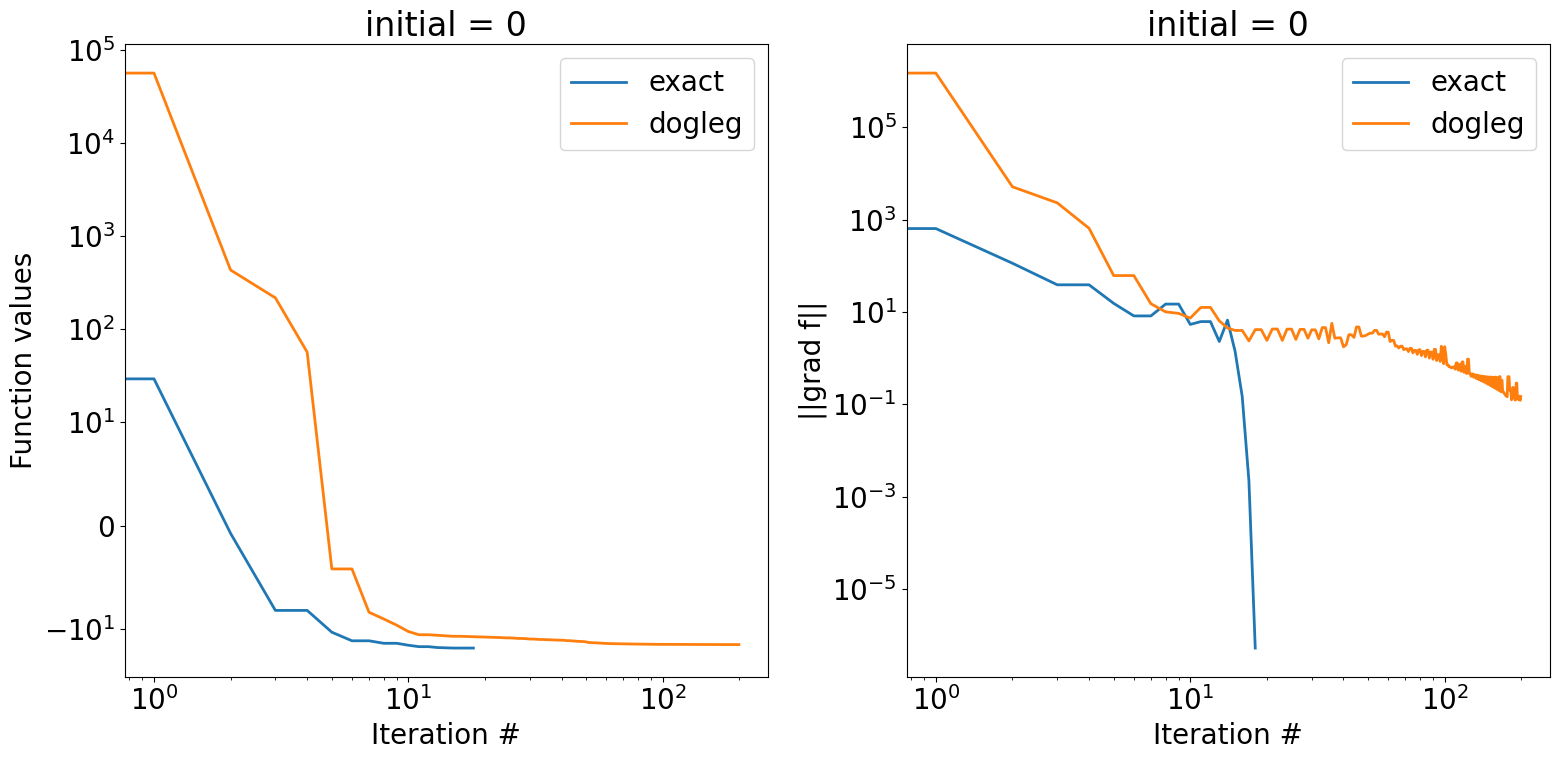

In [6]:
#random initials
initial=0
for i in range(10):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(16,8))
    direction_dict = {1:"Newton",2:"BFGS"} #0:"Steepest Descent",
    plot_dict = {1:"exact",2:"dogleg"} # 

    for direction in direction_dict:
        fvals, ngvals , itr=descend(initial,direction_dict[direction])
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(itr),fvals[0:itr],linewidth = 2, label=plot_dict[direction]) #todo less than itermax
        plt.title("initial = "+str(initial))
        plt.xlabel("Iteration #")
        plt.xscale("log")
        plt.ylabel("Function values")
        plt.yscale('symlog', linthresh=10)
        plt.legend()
        #second plot of gradients
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(itr),ngvals[0:itr],linewidth = 2, label=plot_dict[direction])
        plt.title("initial = "+str(initial))
        plt.xlabel("Iteration #")
        plt.xscale("log")
        plt.ylabel("||grad f||")
        plt.yscale("log")
        plt.legend()
    plt.tight_layout()    
    plt.show()
    
    #todo: change all to l